# Constraint Satisfaction Problems

This notebook serves as a supporting material for Chapter 6 **Constraint Satisfaction Problems**. In this notebook, we demonstrate how the [csp package][1] can be used to solve problems that can be formulated as CSPs. We use **factored representation** for the states in a CSP. We will see that by deviating from the notion of atomic states, we can use general purpose inference techniques and search heuristics to solve any CSP. Hence, a CSP solver can be used to solve any problem once it has been formulated as a CSP. Let's begin by loading the `aima-core` jar file.

[1]: https://github.com/aimacode/aima-java/tree/AIMA3e/aima-core/src/main/java/aima/core/search/csp

In [1]:
%classpath add jar ../out/artifacts/aima_core_jar/aima-core.jar

# Defining constraint Satisfaction Problems 

Let's begin with formally defining a CSP. Later, we will dive into the code repository and explore the CSP class.

As per the textbook, a constraint satisfaction problem consists of three components, $X$, $D$, and $C$:
* $X$ is a set of [variables][1], $\{X_1,...,X_n\}$.
* $D$ is a set of [domains][2], $\{D_1,...,D_n\}$, one for each variable.
* $C$ is a set of [constraints][3] that specify allowable combinations of values.


Each domain $D_i$ consists of a set of allowable values, $\{v_1,...,v_k\}$ for variable $X_i$. Each constraint $C_i$ consists of a pair $<scope,rel>$, where $scope$ is a tuple of variables that participate in the constraint and $rel$ is a relation that defines the values that those variables can take on. A relation can be represented as an explicit list of all tuples of values that satisfy the constraint, or as an abstract relation that supports two operations: testing if a tuple is a member of the relation and enumerating the members of the relation.

Let's take a look at the [CSP class][4] in the code repository and then we will move on to formally defining our first problem.

[1]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Variable.java
[2]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Domain.java
[3]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Constraint.java
[4]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/CSP.java

The class takes generics `VAR` and `VAL` for the type of variables and the values they can take respectively. The data structures used in the class include:
* `List<VAR> variables`: The list of all variables in the CSP
* `List<Domain<VAL>> domains`: The corresponding domains of the variables
* `List<Constraint<VAR, VAL>> constraints`: The list of different constraints in the CSP
* `Hashtable<Variable, Integer> varIndexHash`: A lookup table that stores the index of variable $X_i$ in the `variables` list
* `Hashtable<Variable, List<Constraint<VAR, VAL>>> cnet`: This is an adjacency list representation of the **constraint hypergraph**

The class also contains the following useful methods:
* `CSP()`: constructor that initializes an empty CSP
* `CSP(List<VAR> vars)`: constructor that initializes the CSP with given variables
* `void addVariable(VAR var)`: Adds a new variable to the CSP
* `List<VAR> getVariables()`: Lists all variables currently in the CSP
* `void setDomain(VAR var, Domain<VAL> domain)`: Used to specify the *domain* of the variable *var*
* `Domain<VAL> getDomain(Variable var)`: Returns the domain of the variable *var*
* `boolean removeValueFromDomain(VAR var, VAL value)`: Modifies the domain of the variable *var* by removing a particular value from it
* `void addConstraint(Constraint<VAR, VAL> constraint)`: Adds a constraint to the CSP
* `boolean removeConstraint(Constraint<VAR, VAL> constraint)`: Removes a constraint from the CSP
* `List<Constraint<VAR, VAL>> getConstraints()`: Returns all constraints in the CSP
* `List<Constraint<VAR, VAL>> getConstraints(Variable var)`: Returns all constraints that concern with the variable *var*
* `VAR getNeighbor(VAR var, Constraint<VAR, VAL> constraint)`: Returns the second variable $neighbor$ in the constraint for a binary constraint $<(var,neighbor),rel>$

Before moving further, let's talk about an [Assignment][1]. An **assignment** can be considered as a state in the CSP where values are assigned to *some* or *all* variables. An assignment that obeys each and every constraint is called a **consistent assignment**. If all variables have been assigned some value, then it's a **complete assignment** otherwise it's known as a **partial assignment**.

[1]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Assignment.java

## Example Problems 

### Map coloring
This simple problem is taken from the textbook (3rd edition: Section 6.1.1, Page 207). The task is simple. We need to color the regions in the australia map such that no two region sharing a boundary have the same color.

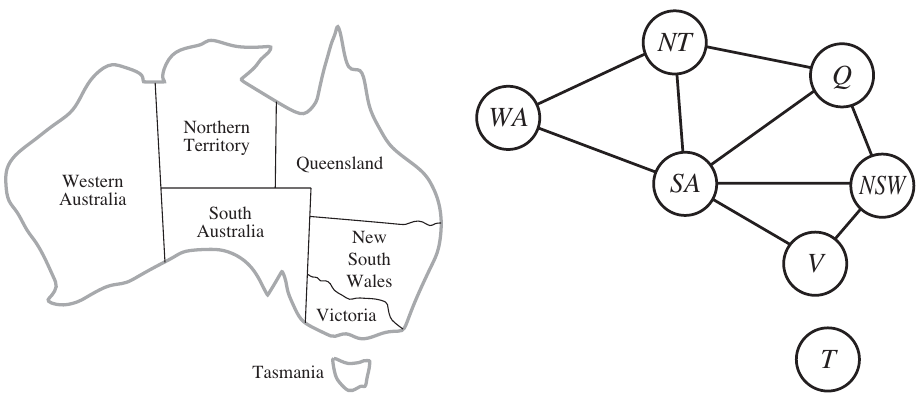

Only constraint we will be using in the map coloring CSP is the *Alldiff* constraint. *Alldiff* constraint is a **global constraint** (constraint involving arbitrary number of variables) that restricts the variables to not take the same value. For e.g., let $A$, $B$ and $C$ be variables with the same domain $D_A=D_B=D_C=\{1,2,5,6,7\}$. Then, the constraint *Alldiff*$(A,B,C)$ can be enumerated as 
    $$\{(1,2,5),(1,2,6),(1,2,7),(1,5,6),(1,5,7),(1,6,7),(2,5,6),(2,5,7),(2,6,7),(5,6,7)\}$$

The map coloring problem can be represented as a CSP as follows:
* **variables:** Each region in the map represents a variable in the CSP. For keeping things simple, we will name the variables with the initials of the region (e.g., Northern Territory -> NT). Thus, $X = \{WA,NT,Q,NSW,V,SA,T\}$
* **domains:** The domain of a variable includes various colors that the corresponding region can be colored with. In this case, all the variables have the same domain consisting of colors *red*, *green* and *blue*. That is, $D_i = \{red,green,blue\}$ for $i=1,2,...,7$.
* **constraints:** Since any set of regions having a common boundary can't be of same color, we introduce the constraints *Alldiff*$(WA,NT,SA)$, *Alldiff*$(NT,SA,Q)$, *Alldiff*$(SA,Q,NSW)$ and *Alldiff*$(SA,NSW,V)$. These *Alldiff* constraints can be simplified to binary [*NotEqualConstraint*][1] constraints (as shown in the constraint graph above), but we will proceed with *Alldiff* as the *NotEqualConstraint* is already implemented in the code repository.

Now that we have formally defined our problem as a CSP, we can begin writing code using the general classes and interfaces in the CSP package. 

We begin by creating the variables for this CSP:


[1]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/examples/NotEqualConstraint.java

In [3]:
package aima.notebooks.csp;

import aima.core.search.csp.Variable;
import java.util.Arrays;
import java.util.List;

public class Variables {
    public static final Variable WA = new Variable("WA");
    public static final Variable NT = new Variable("NT");
    public static final Variable Q = new Variable("Q");
    public static final Variable NSW = new Variable("NSW");
    public static final Variable V = new Variable("V");
    public static final Variable SA = new Variable("SA");
    public static final Variable T = new Variable("T");
    
    public static final List<Variable> list = Arrays.asList(WA, NT, Q, NSW, V, SA, T);
    
    private Variables() {}
}

aima.notebooks.csp.Variables

What about domains? We will declare a class that encapsulates the domains of the variables we just instantiated.

In [5]:
package aima.notebooks.csp;

public class Values {
    public static final String RED = "red";
    public static final String GREEN = "green";
    public static final String BLUE = "blue";
    
    private Values() {}
}

aima.notebooks.csp.Values

In [6]:
package aima.notebooks.csp;

import aima.core.search.csp.Domain;
import java.util.List;
import java.util.Arrays;
import java.util.ArrayList;

public class Domains {
    private static final List<String> commonDomain = Arrays.asList(Values.RED, Values.GREEN, Values.BLUE);
    public static final Domain<String> WA = new Domain(new ArrayList<String>(commonDomain));
    public static final Domain<String> NT = new Domain(new ArrayList<String>(commonDomain));
    public static final Domain<String> Q = new Domain(new ArrayList<String>(commonDomain));
    public static final Domain<String> NSW = new Domain(new ArrayList<String>(commonDomain));
    public static final Domain<String> V = new Domain(new ArrayList<String>(commonDomain));
    public static final Domain<String> SA = new Domain(new ArrayList<String>(commonDomain));
    public static final Domain<String> T = new Domain(new ArrayList<String>(commonDomain));
    
    public static final List<Domain> list = Arrays.asList(WA, NT, Q, NSW, V, SA, T);
    
    private Domains() {}
}

aima.notebooks.csp.Domains

Last hurdle that remains are the constraints. There's no *Alldiff* constraint in the CSP package. But we can create a class that implements the [Constraint interface][1] and doesn't allows the variables to take same values. We will need the [Assignment class][2] to denote a mapping of variables to their values. This class contains useful query methods like `isComplete()`, `isConsistent()`, `isSolution()`, etc.. It also contains other methods to modify the state of the class.

[1]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Constraint.java
[2]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Assignment.java

In [8]:
package aima.notebooks.csp;

import aima.core.search.csp.Constraint;
import aima.core.search.csp.Variable;
import aima.core.search.csp.Assignment;
import java.util.List;
import java.util.ArrayList;
import java.util.HashSet;

public class AllDiffConstraint<VAR extends Variable, VAL> implements Constraint<VAR, VAL> {
    
    private List<VAR> variables;
    
    public AllDiffConstraint(List<VAR> variables) {
        this.variables = variables;
    }
    
    @Override
    public List<VAR> getScope() {
        return variables;
    }
    
    @Override
    public boolean isSatisfiedWith(Assignment<VAR, VAL> assignment) {
        HashSet<VAL> valueSet = new HashSet();
        for (VAR variable: variables) {
            if (assignment.contains(variable)) {
                VAL value = assignment.getValue(variable);
                if (!valueSet.add(value)) {
                    return false;
                }
            }
        }
        return true;
    }
    
    @Override
    public String toString() {
        StringBuilder sbl = new StringBuilder();
        sbl.append("Alldiff(");
        for (Variable variable: variables.subList(0, variables.size() - 1)) {
            sbl.append(variable.toString()).append(", ");
        }
        sbl.append(variables.get(variables.size() - 1)).append(")");
        return sbl.toString();
    }
    
}

aima.notebooks.csp.AllDiffConstraint

Time to see the AllDiffConstraint class in action!

In [9]:
package aima.notebooks.csp;

import aima.core.search.csp.*;

Assignment<Variable, String> assignment = new Assignment();
assignment.add(Variables.WA, Values.BLUE);
assignment.add(Variables.NT, Values.RED);
assignment.add(Variables.SA, Values.GREEN);

Assignment<Variable, String> nonConsistentAssignment = assignment.clone();
nonConsistentAssignment.add(Variables.NSW, Values.RED);

AllDiffConstraint alldiff = new AllDiffConstraint(Variables.list);

return alldiff.isSatisfiedWith(assignment) + ", " + alldiff.isSatisfiedWith(nonConsistentAssignment);

true, false

We can now define the Map CSP constraints using the AllDiffConstraint class we just created.

In [12]:
package aima.notebooks.csp;

import static aima.notebooks.csp.Variables.*;
import java.util.List;
import java.util.Arrays;

public class Constraints {
    public static final List<AllDiffConstraint> list = Arrays.asList(
        new AllDiffConstraint(Arrays.asList(WA, NT, SA)),
        new AllDiffConstraint(Arrays.asList(NT, SA, Q)),
        new AllDiffConstraint(Arrays.asList(SA, Q, NSW)),
        new AllDiffConstraint(Arrays.asList(SA, NSW, V))
    );
    private Constraints() {}
}

aima.notebooks.csp.Constraints

We can now encapsulate the variables, their respective domains and the constraints involved in a class **MapCSP.java** that extends the [CSP class][1] in the csp package.

[1]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/CSP.java

In [16]:
package aima.notebooks.csp;

import aima.core.search.csp.CSP;
import aima.core.search.csp.Variable;
import aima.core.search.csp.Domain;
import java.util.Iterator;

public class MapCSP extends CSP<Variable, String> {
    
    public MapCSP() {
        super(Variables.list);
        Iterator<Domain> domainIter = Domains.list.listIterator();
        Variables.list.forEach(
            variable -> super.setDomain(variable, domainIter.next())
        );
        Constraints.list.forEach(super::addConstraint);
    }
    
}

aima.notebooks.csp.MapCSP

Or we can instantiate an object of the CSP class and add the variables, domains and constraints manually. The object thus created will represent our Map CSP. The code for this is very similar hence, it is not shown here.